<a href="https://colab.research.google.com/github/lmoroney/tfbook/blob/master/chapter8/irish-songs-moredata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [50]:
# try:
#   # %tensorflow_version only exists in Colab.
#   %tensorflow_version 2.x
# except Exception:
#   pass


In [51]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np 

In [52]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/irish-lyrics-eof.txt \
    -O /tmp/irish-lyrics-eof.txt

--2021-12-29 15:55:15--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/irish-lyrics-eof.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 142.250.157.128, 142.251.8.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68970 (67K) [text/plain]
Saving to: ‘/tmp/irish-lyrics-eof.txt’

/tmp/irish-lyrics-e 100%[===================>]  67.35K  --.-KB/s    in 0.001s  

2021-12-29 15:55:15 (106 MB/s) - ‘/tmp/irish-lyrics-eof.txt’ saved [68970/68970]



In [53]:
tokenizer = Tokenizer()
max_sequence_len = 6
sentences=[]
alltext=[]
data = open('/tmp/irish-lyrics-eof.txt').read()
corpus = data.lower()
alltext.append(corpus)
words = corpus.split(" ")
range_size = len(words)-max_sequence_len
for i in range(0, range_size):
	thissentence=""
	for word in range(0, max_sequence_len-1):
		word = words[i+word]
		thissentence = thissentence + word
		thissentence = thissentence + " "
	sentences.append(thissentence)

print(sentences[:3])

['come all ye maidens young ', 'all ye maidens young and ', 'ye maidens young and fair\nand ']


In [54]:
oov_tok = "<OOV>"
vocab_size=2700
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok, split=" ", char_level=False)
tokenizer.fit_on_texts(alltext)
total_words = len(tokenizer.word_index) + 1

print(tokenizer.word_index)
print(total_words)


{'<OOV>': 1, 'the': 2, 'and': 3, 'i': 4, 'to': 5, 'a': 6, 'of': 7, 'my': 8, 'in': 9, 'me': 10, 'for': 11, 'you': 12, 'all': 13, 'was': 14, 'she': 15, 'that': 16, 'on': 17, 'with': 18, 'her': 19, 'but': 20, 'as': 21, 'when': 22, 'love': 23, 'is': 24, 'your': 25, 'it': 26, 'will': 27, 'from': 28, 'by': 29, 'they': 30, 'be': 31, 'are': 32, 'so': 33, 'he': 34, 'old': 35, 'no': 36, 'oh': 37, 'ill': 38, 'at': 39, 'one': 40, 'his': 41, 'there': 42, 'were': 43, 'heart': 44, 'down': 45, 'now': 46, 'we': 47, 'where': 48, 'young': 49, 'never': 50, 'go': 51, 'come': 52, 'then': 53, 'did': 54, 'not': 55, 'said': 56, 'away': 57, 'their': 58, 'sweet': 59, 'them': 60, 'green': 61, 'if': 62, 'take': 63, 'our': 64, 'like': 65, 'night': 66, 'day': 67, 'o': 68, 'out': 69, 'fair': 70, 'this': 71, 'town': 72, 'have': 73, 'can': 74, 'true': 75, 'its': 76, 'thou': 77, 'see': 78, 'dear': 79, 'more': 80, 'theres': 81, 'or': 82, 'had': 83, 'would': 84, 'over': 85, 'hear': 86, 'up': 87, 'ive': 88, 'through': 89, 

In [55]:
input_sequences = []
for line in sentences:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

print(input_sequences[:5])

[[52, 13], [52, 13, 97], [52, 13, 97, 1218], [52, 13, 97, 1218, 49], [13, 97]]


In [56]:
# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
print(max_sequence_len)
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

print(input_sequences[:5])

21
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0   52   13]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0   52   13   97]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0   52   13   97 1218]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0   52   13   97 1218   49]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0   13   97]]


In [57]:
# create predictors and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)
print(xs.shape)
print(xs[:5])
print(labels)

(56643, 20)
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0   52]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0   52   13]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0   52   13   97]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0   52   13   97 1218]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0   13]]
[  13   97 1218 ...  325   48  106]


In [58]:
model = Sequential()
model.add(Embedding(total_words, 16, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(total_words, activation='softmax'))

adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(xs, ys, epochs=20, verbose=1)
# model.save("bidiirish2.h5")

Epoch 1/20
1771/1771 [==============================] - 53s 26ms/step - loss: 6.0508 - accuracy: 0.0857
Epoch 2/20
1771/1771 [==============================] - 46s 26ms/step - loss: 5.2176 - accuracy: 0.1349
Epoch 3/20
1771/1771 [==============================] - 46s 26ms/step - loss: 4.5695 - accuracy: 0.1776
Epoch 4/20
1771/1771 [==============================] - 46s 26ms/step - loss: 4.0564 - accuracy: 0.2171
Epoch 5/20
1771/1771 [==============================] - 46s 26ms/step - loss: 3.6815 - accuracy: 0.2508
Epoch 6/20
1771/1771 [==============================] - 46s 26ms/step - loss: 3.4084 - accuracy: 0.2835
Epoch 7/20
1771/1771 [==============================] - 46s 26ms/step - loss: 3.1920 - accuracy: 0.3122
Epoch 8/20
1771/1771 [==============================] - 46s 26ms/step - loss: 3.0217 - accuracy: 0.3349
Epoch 9/20
1771/1771 [==============================] - 46s 26ms/step - loss: 2.8814 - accuracy: 0.3568
Epoch 10/20
1771/1771 [==============================] - 46s 26m

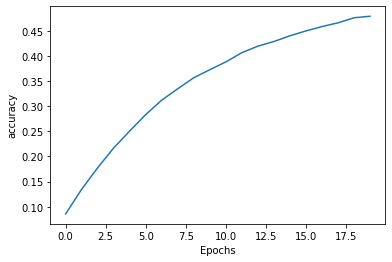

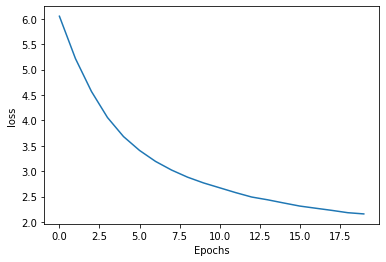

In [59]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')


In [60]:
seed_text = "Come all ye maidens young and"  # next word "fair"
next_words = 10       
for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
  predicted = np.argmax(model.predict(token_list), axis=-1)
  output_word = ""
  for word, index in tokenizer.word_index.items():
    if index == predicted:
      output_word = word
      break
  seed_text += " " + output_word

print(seed_text)

Come all ye maidens young and in a view oer me that well raise the cheer


In [61]:
seed_text = "Come all ye maidens young and"                        # next word would be fair
token_list = tokenizer.texts_to_sequences([seed_text])[0]
token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
predicted = np.argmax(model.predict(token_list), axis=-1)
print(predicted)

for word, index in tokenizer.word_index.items():
    if index == predicted:
        print(word)
        break

# seed_text = "are you feeling lucky"
next_words = 100
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')
    # predicted = model.predict_classes(token_list, verbose=0)
    predicted = np.argmax(model.predict(token_list), axis=-1)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word

print(seed_text)


[9]
in
Come all ye maidens young and in a view oer me that well raise the cheer revenge for skibbereen with whiskey and loved its you leave my meaning i never would me embarrass besides sir to die on the sentence wont sold and the high high left a walk along the way and ld nice roddy mccorley goes to late they through the indies jollity where she boldly took a tear and the way and ld could they keep me oh danny both loud and gave to the stars ache and the cold thing in rosy red coat bit the devil not no never began abusing


In [62]:
# seed_text = "sweet jeremy saw dublin"

# token_list = tokenizer.texts_to_sequences([seed_text])[0]
# token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
# #print(model.predict(token_list))  
# predicted = model.predict_classes(token_list)
# pred_classes=model.predict(token_list)
# print(pred_classes.reshape(-1)[predicted])
# print(predicted)
# for word, index in tokenizer.word_index.items():
# 	if index == predicted:
# 		print(word)
# 		break

In [63]:
# seed_text = "are you feeling lucky"
# next_words = 100

  
# for _ in range(next_words):
# 	token_list = tokenizer.texts_to_sequences([seed_text])[0]
# 	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
# 	predicted = model.predict_classes(token_list, verbose=0)
# 	output_word = ""
# 	for word, index in tokenizer.word_index.items():
# 		if index == predicted:
# 			output_word = word
# 			break
# 	seed_text += " " + output_word
# print(seed_text)